In [2]:
library(tidyverse)
theme_set(theme_classic())
options(repr.plot.width  = 10, repr.plot.height = 6, repr.plot.res = 150)
options(jupyter.rich_display=T)
set.seed(1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# STATS 504
## Week 12: More on mapping & spatial stats

In [1]:
load("flint.RData")

In [3]:
flint_geocode

Sample Number,Date Submitted,Analysis (Lead),Lead (ppb),Analysis (Copper),Copper (ppb),Street #,Street Name,City,Zip Code,addr,lat,long
<chr>,<dttm>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LF84899,2015-09-25 11:07:30,Lead,0,Copper,0,1930,COLCHESTER RD,FLINT,48503,1930 COLCHESTER RD FLINT MI 48503,42.99443,-83.72368
LF85330,2015-09-29 14:35:09,Lead,0,Copper,0,1505,W COURT ST/POWERS CATHOLIC SCH,FLINT,48503,1505 W COURT ST/POWERS CATHOLIC SCH FLINT MI 48503,43.00676,-83.70365
LF85604,2015-09-30 13:06:52,Lead,0,Copper,220,605,GARLAND ST /2,FLINT,48503,605 GARLAND ST /2 FLINT MI 48503,43.02062,-83.69630
LF85613,2015-09-30 13:07:02,Lead,0,Copper,0,4307,OGEMA AVE,FLINT,48507,4307 OGEMA AVE FLINT MI 48507,42.98497,-83.66088
LF85796,2015-10-01 11:10:35,Lead,0,Copper,140,2422,BASSETT PL,FLINT,48504,2422 BASSETT PL FLINT MI 48504,43.03843,-83.72347
LF85797,2015-10-01 11:10:36,Lead,0,Copper,0,3729,WOODROW AVE,FLINT,48506,3729 WOODROW AVE FLINT MI 48506,43.03786,-83.63973
LF85799,2015-10-01 11:10:38,Lead,0,Copper,50,3617,CHURCHILL AVE,FLINT,48506,3617 CHURCHILL AVE FLINT MI 48506,43.03390,-83.64209
LF85802,2015-10-01 11:10:41,Lead,0,Copper,270,1222,INGLESIDE AVE,FLINT,48507,1222 INGLESIDE AVE FLINT MI 48507,42.98385,-83.69607
LF85862,2015-10-01 12:46:38,Lead,0,Copper,330,605,CHANDLER AVE,FLINT,48503,605 CHANDLER AVE FLINT MI 48503,43.02087,-83.66006


In [4]:
library(tidycensus)
options(tigris_use_cache = TRUE)

zcta <- get_acs(
  geography = "zcta",
  variables = "B19013_001",
  geometry = TRUE,
  year = 2020
)
# B19013_001 -- Median household income (in inflation-adjusted dollars).


Getting data from the 2016-2020 5-year ACS

Warning message:
“• You have not set a Census API key. Users without a key are limited to 500
queries per day and may experience performance limitations.
ℹ For best results, get a Census API key at
http://api.census.gov/data/key_signup.html and then supply the key to the
`census_api_key()` function to use it throughout your tidycensus session.
This warning is displayed once per session.”


  |======================================================================| 100%


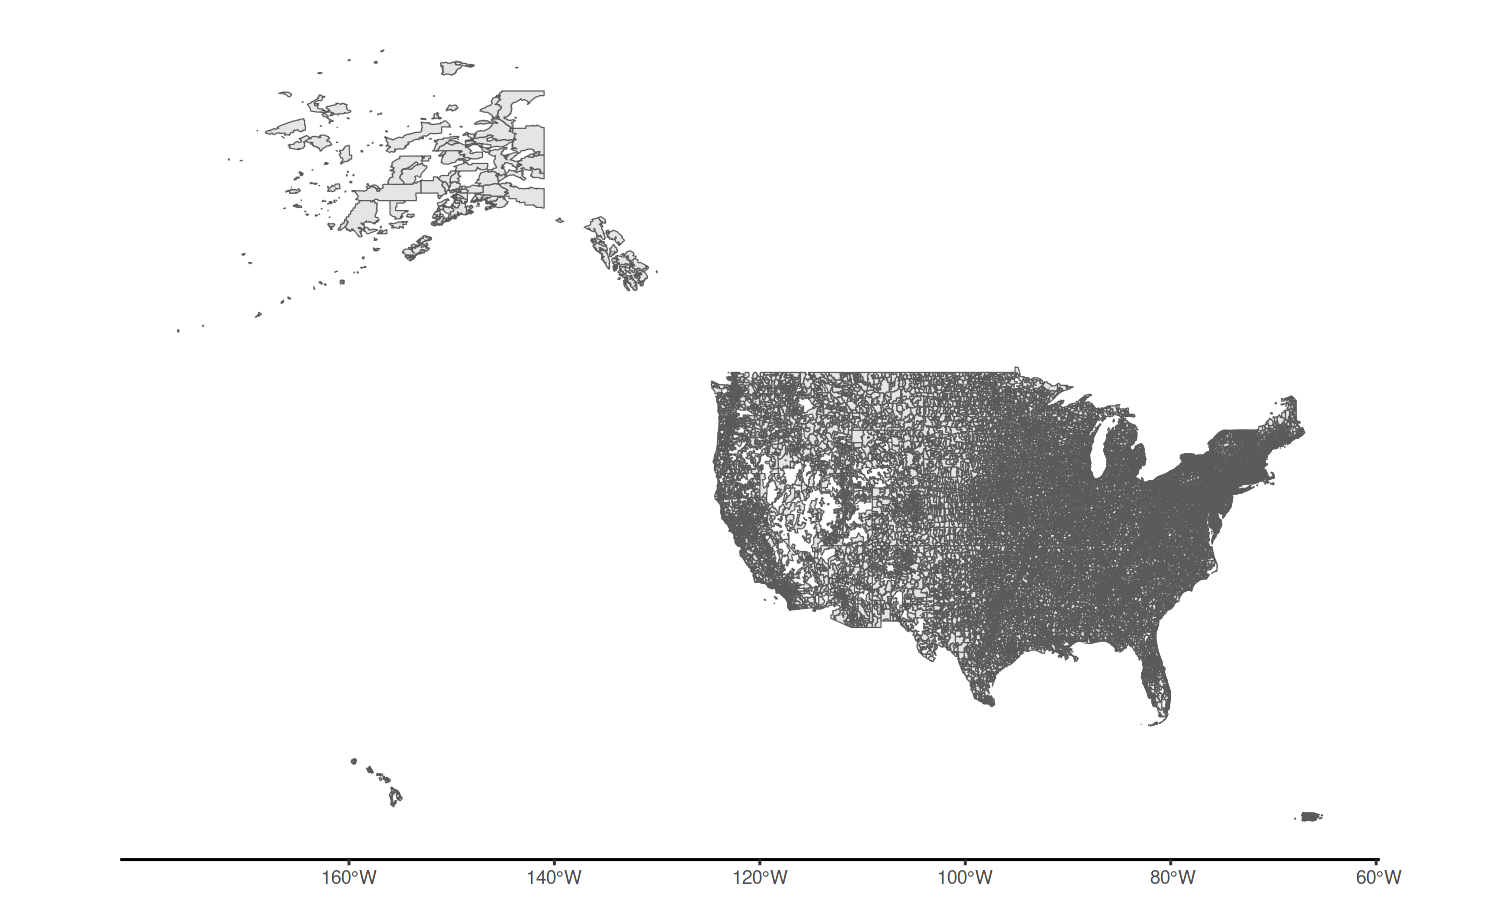

In [265]:
ggplot(zcta) + geom_sf()

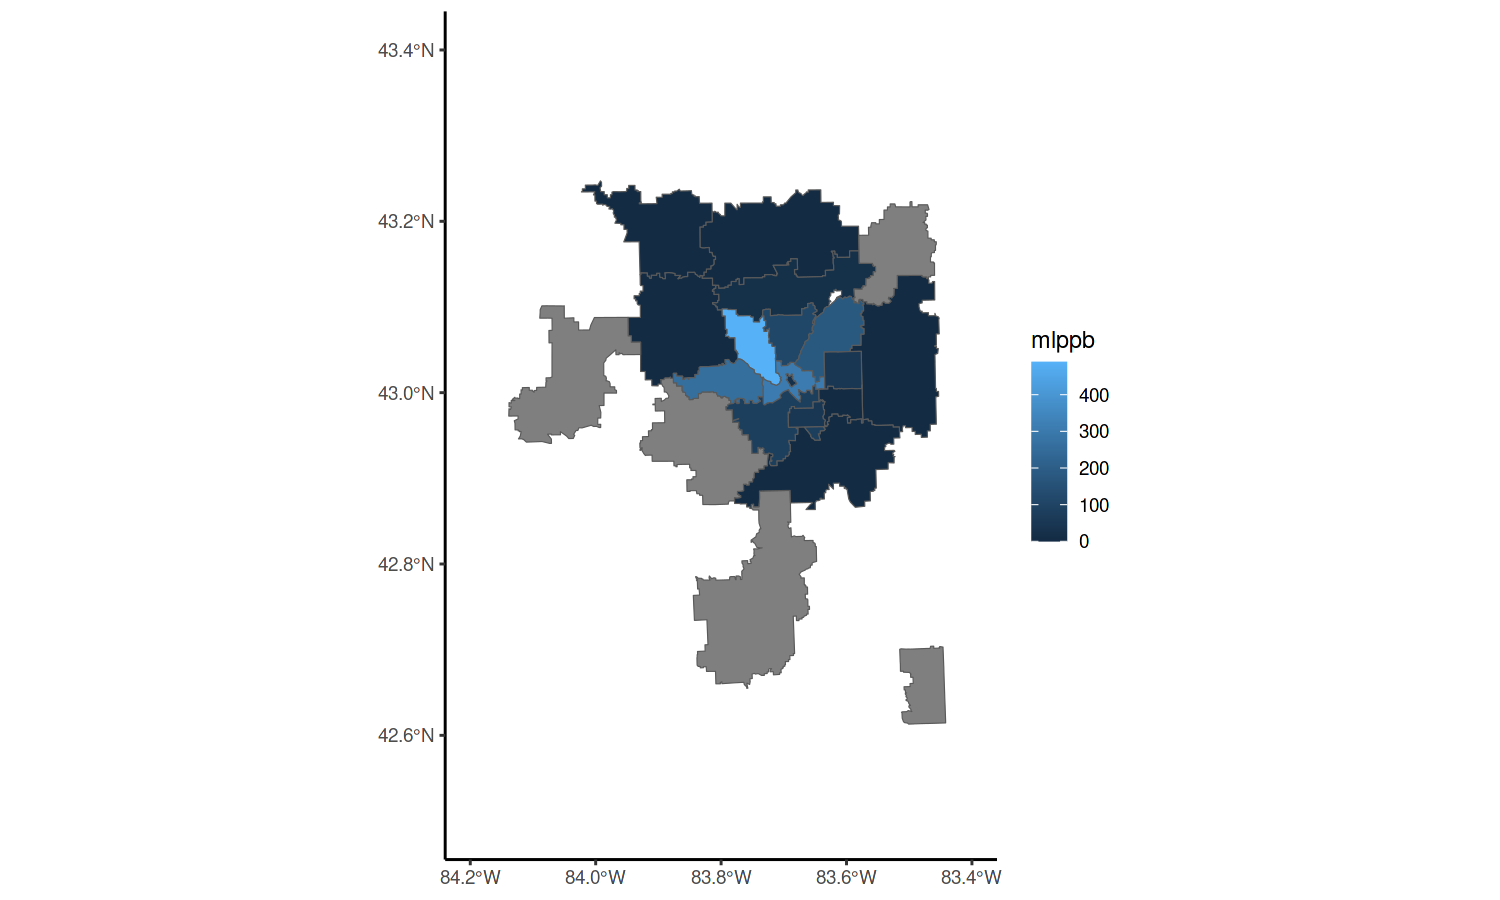

In [304]:
library(sf)
library(ggspatial)

flint %>% group_by(`Zip Code`) %>% 
    summarize(mlppb = sd(`Lead (ppb)`), na.rm = T) %>%
    inner_join(zcta, join_by(`Zip Code` == GEOID)) %>% 
    st_as_sf %>%  
    ggplot + geom_sf(aes(fill = mlppb)) +
    xlim(c(-84.2, -83.4)) + ylim(c(42.5, 43.4))


## Spatial join
- Next, I want to average the lead levels, also by census tract.
- To do this I need to perform a *spatial join*: I want to match each row in `flint_geocode` with the census tract that encloses it.

In [6]:
library(tidycensus)
options(tigris_use_cache = TRUE)

genesee <- get_acs(
  state = "MI",
  county = "Genesee",
  geography = "tract",
  variables = "B19013_001",
  geometry = TRUE,
  year = 2020
)

genesee %>% head

Getting data from the 2016-2020 5-year ACS



,GEOID,NAME,variable,estimate,moe,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,26049011212,"Census Tract 112.12, Genesee County, Michigan",B19013_001,44394,8504,MULTIPOLYGON (((-83.69252 4...
2,26049000300,"Census Tract 3, Genesee County, Michigan",B19013_001,25230,11181,MULTIPOLYGON (((-83.7334 43...
3,26049001200,"Census Tract 12, Genesee County, Michigan",B19013_001,49211,8143,MULTIPOLYGON (((-83.74237 4...
4,26049003800,"Census Tract 38, Genesee County, Michigan",B19013_001,24311,17383,MULTIPOLYGON (((-83.692 43....
5,26049010501,"Census Tract 105.01, Genesee County, Michigan",B19013_001,34950,13209,MULTIPOLYGON (((-83.76291 4...
6,26049010201,"Census Tract 102.01, Genesee County, Michigan",B19013_001,73221,12581,MULTIPOLYGON (((-83.81449 4...


Linking to GEOS 3.13.0, GDAL 3.8.5, PROJ 9.5.1; sf_use_s2() is TRUE

Warning message:
“There were 43 warnings in `summarize()`.
The first warning was:
ℹ In argument: `mlppb = max(log10(`Lead (ppb)`), na.rm = T)`.
ℹ In group 6: `geometry = MULTIPOLYGON (((-83.81449 4...`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 42 remaining warnings.”


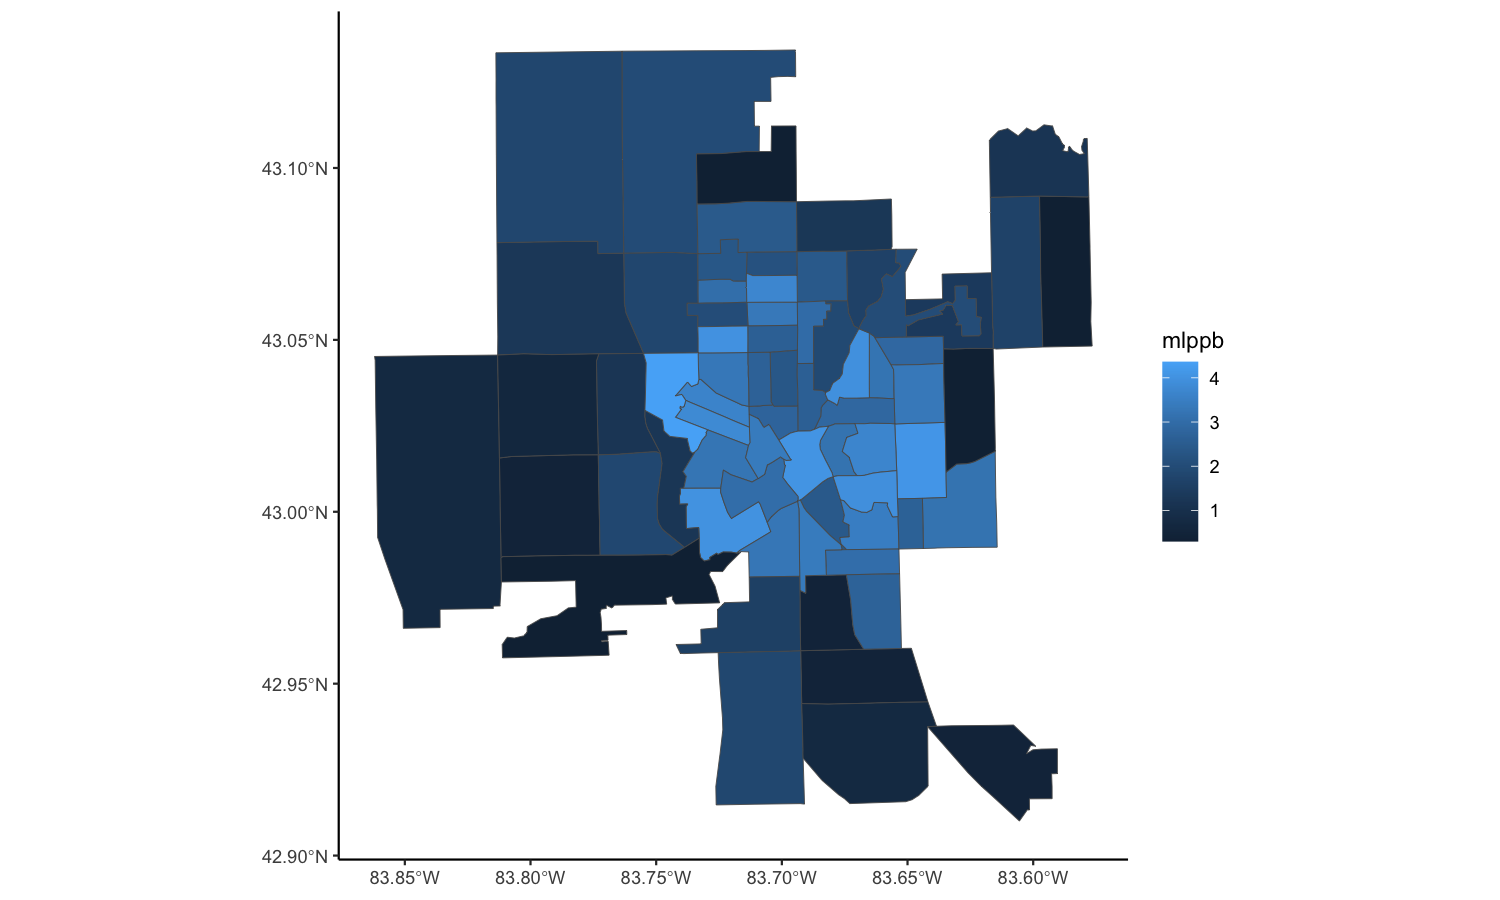

In [8]:
library(sf)
flint_geocode %>% 
    drop_na(long, lat) %>% 
    st_as_sf(coords = c("long", "lat"), crs = "NAD83") %>%
    st_join(genesee, .) %>%
    group_by(geometry) %>% summarize(mlppb = max(log10(`Lead (ppb)`), na.rm = T)) %>%
    filter(mlppb > 0) %>% 
    ggplot + geom_sf(aes(fill = mlppb))

Warning message:
“There were 43 warnings in `summarize()`.
The first warning was:
ℹ In argument: `mlppb = max(log10(`Lead (ppb)`), na.rm = T)`.
ℹ In group 6: `geometry = MULTIPOLYGON (((-83.81449 4...`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 42 remaining warnings.”


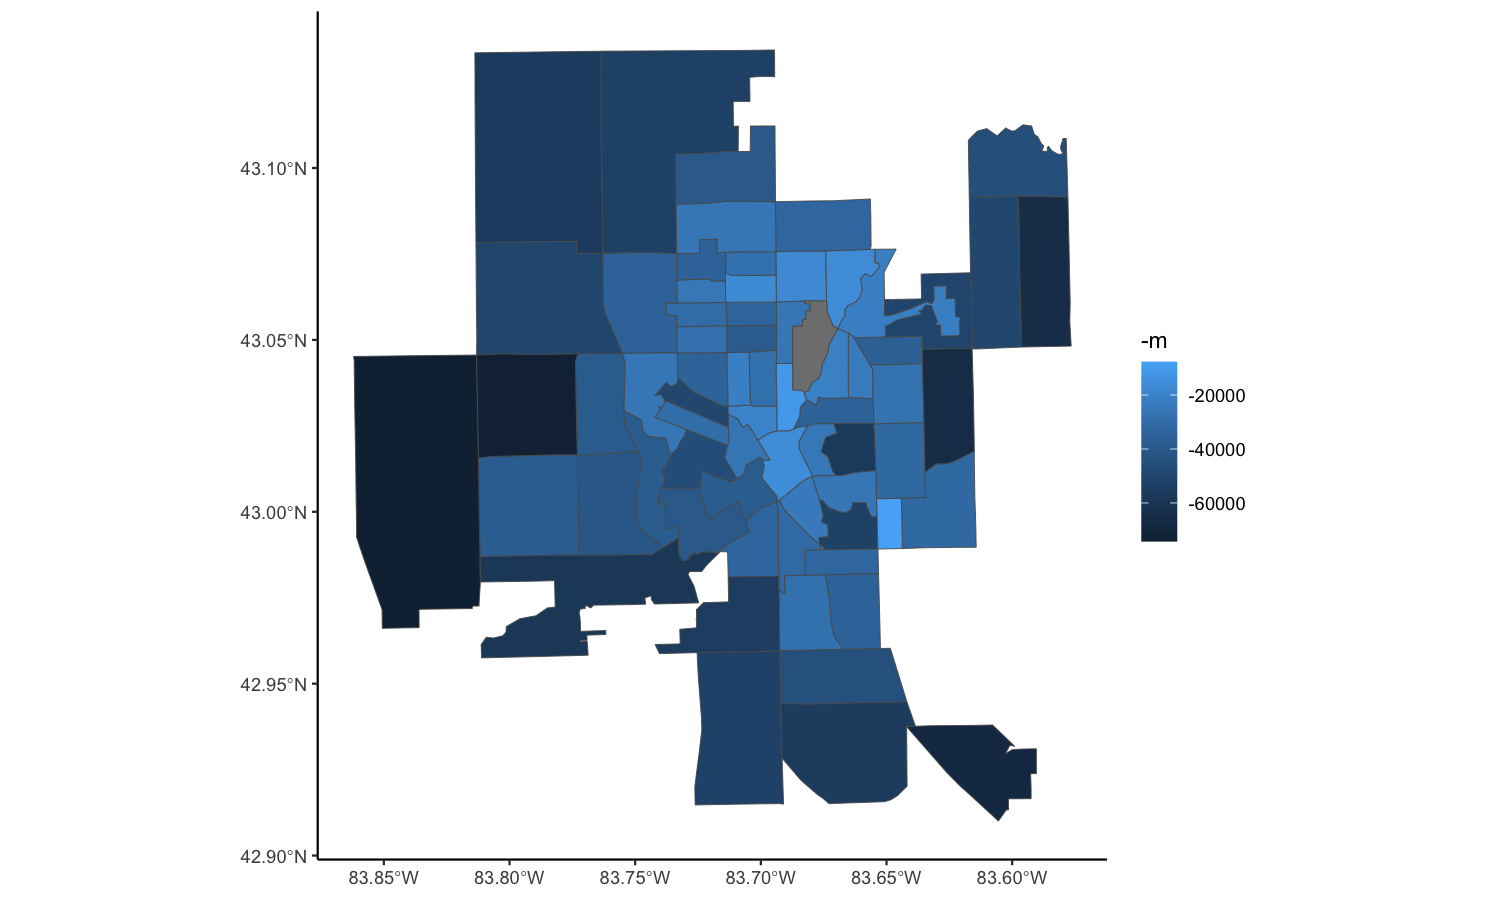

In [11]:
flint_geocode %>% 
    drop_na(long, lat) %>% 
    st_as_sf(coords = c("long", "lat"), crs = "NAD83") %>%
    st_join(genesee, .) %>%
    group_by(geometry) %>% summarize(m=mean(estimate), mlppb = max(log10(`Lead (ppb)`), na.rm = T)) %>%
    filter(mlppb > 0) %>% 
    ggplot + geom_sf(aes(fill = -m))

## Biases when looking at maps

- Maps can be very informative but also induce subtle visual biases. 
- Examples:
    - Area not proportional to quantity plotted
    - Differences in coloring (choropleths) can lead to dramatically different interpretations
- See https://pitchinteractiveinc.github.io/tilegrams/ for interesting ways to visualize political data in the US and other countries

![cartogram](https://handsondataviz.org/images/14-detect/conventional-cartogram-combined.png)

Here are three different ways to visualize income global inequality. All three are working with the exact same underlying data:
- https://datawrapper.dwcdn.net/aetEM/3/
- https://datawrapper.dwcdn.net/VSfdZ/3/
- https://datawrapper.dwcdn.net/YfNDe/2/ 

![underlying data](https://handsondataviz.org/images/14-detect/map-data-histogram-annotated.png)

## Modeling association between lead levels and HHI

- We hypothesize that there is a significant association between HHI and lead content.
- How can we test?

Warning message:
“There were 43 warnings in `summarize()`.
The first warning was:
ℹ In argument: `mlppb = max(log10(`Lead (ppb)`), na.rm = T)`.
ℹ In group 6: `geometry = MULTIPOLYGON (((-83.81449 4...`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 42 remaining warnings.”


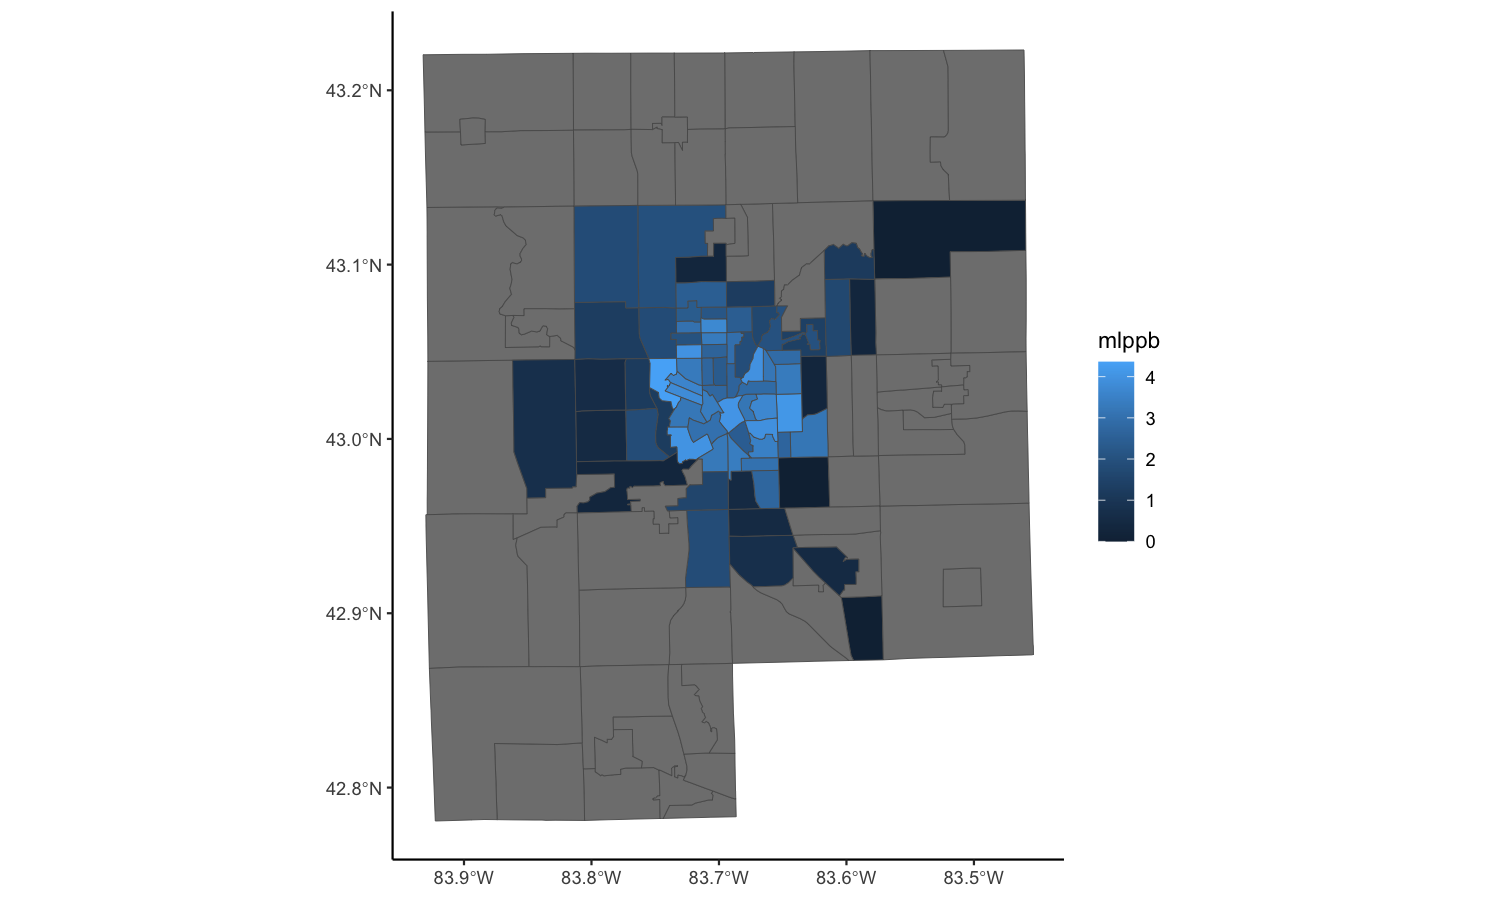

In [15]:
flint_geocode %>% 
    drop_na(long, lat) %>% 
    st_as_sf(coords = c("long", "lat"), crs = "NAD83") %>%
    st_join(genesee, .) %>%
    group_by(geometry) %>% 
    summarize(mlppb = max(log10(`Lead (ppb)`), na.rm = T), income = mean(estimate)) ->
    df

ggplot(df) + geom_sf(aes(fill = mlppb))

In [16]:
df %>% drop_na %>% filter(mlppb>0) %>% mutate(income1k = income / 1000) -> df
mdl <- lm(mlppb ~ income, df) 
summary(mdl)


Call:
lm(formula = mlppb ~ income, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.26234 -0.71146  0.00301  0.65026  2.20810 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.940e+00  3.195e-01  12.332  < 2e-16 ***
income      -4.275e-05  8.043e-06  -5.315  1.4e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9878 on 65 degrees of freedom
Multiple R-squared:  0.303,	Adjusted R-squared:  0.2922 
F-statistic: 28.25 on 1 and 65 DF,  p-value: 1.396e-06


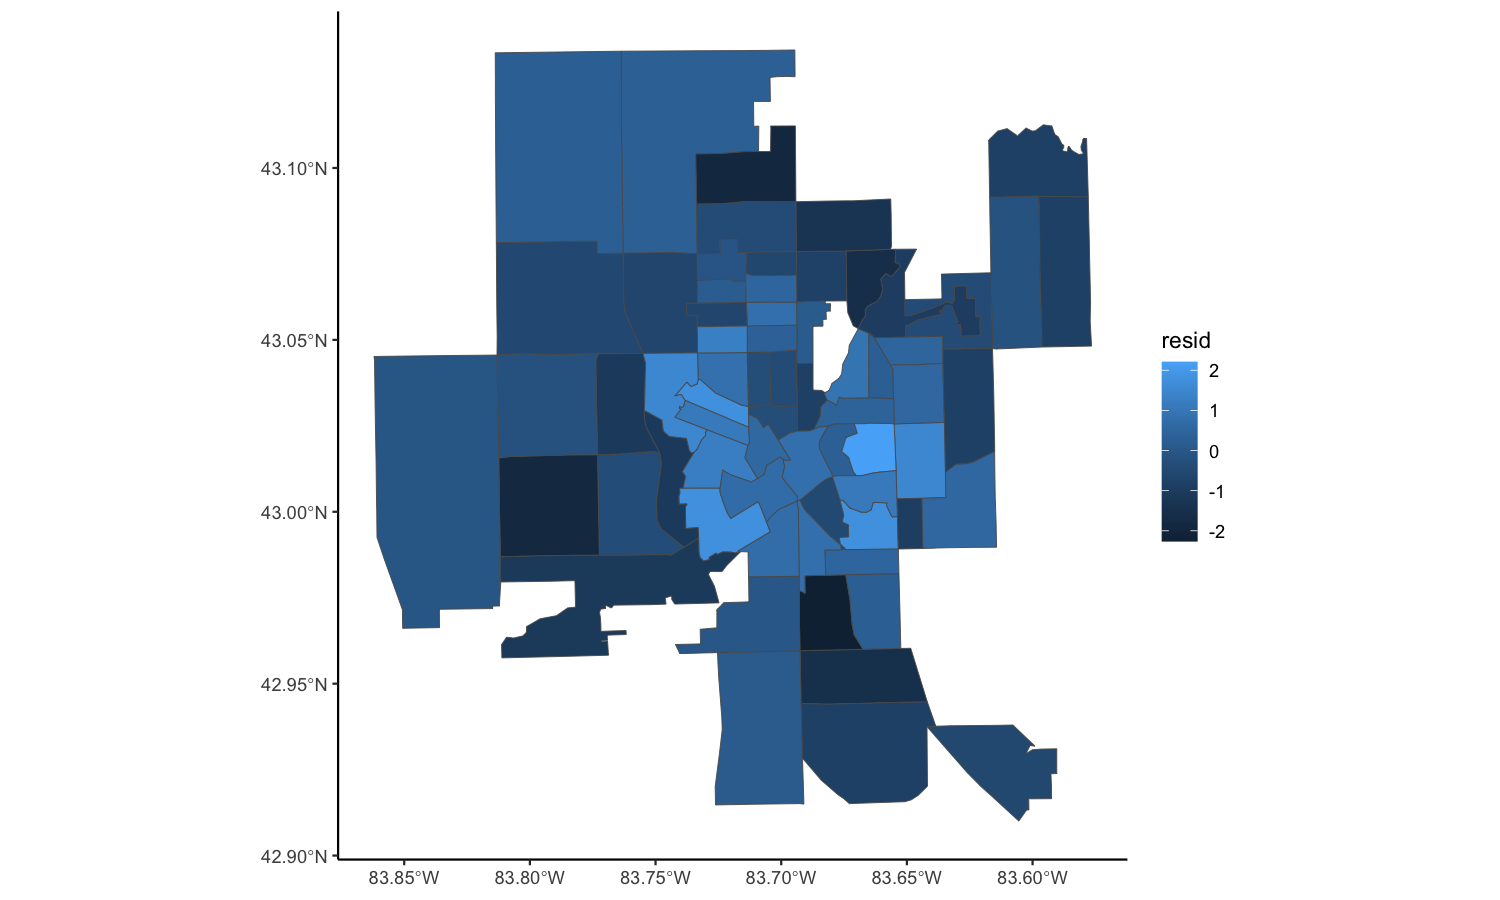

In [17]:
df$resid <- residuals(mdl)

ggplot(df) + geom_sf(aes(fill = resid))

## Spatial autocorrelation
- [“Everything is related to everything else, but near things are more related than distant things"](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography#:~:text=The%20First%20Law%20of%20Geography,specifically%20for%20the%20inverse%20distance)
- To test whether there is a spatial component to our data, we need to formally model spatial dependency.
- Need to define:
  - Connectivity (what is next to what)
  - Weight (strength of dependence on neighbors)

## Moran's I

- Imagine you’re looking at a map displaying temperatures.
- You might notice that areas close to each other tend to have similar temperatures—warm areas are near other warm areas, and cool areas are near other cool areas. 
- This tendency for similar values to cluster spatially is what Moran’s I measures on a global scale.

![global temps](https://upload.wikimedia.org/wikipedia/commons/a/aa/Annual_Average_Temperature_Map.jpg)



$$ I \propto \frac {\sum_{i=1}^N \sum_{j=1}^N w_{ij}(x_i-\bar x) (x_j-\bar x)} {\sum_{i=1}^N (x_i-\bar x)^2} $$

- The $w_{ij}$ are "spatial weights"
- The numerator measures the spatial cross-product of deviations from the mean, weighted by the spatial weights.
- The denominator normalizes this by the total variance.
- Just as Pearson’s $r$ measures the strength and direction of a linear relationship between two variables, Moran’s $I$ measures the degree of similarity between a variable’s values at different locations and the spatial proximity of those locations.
- Local I: fix the $i$ index.

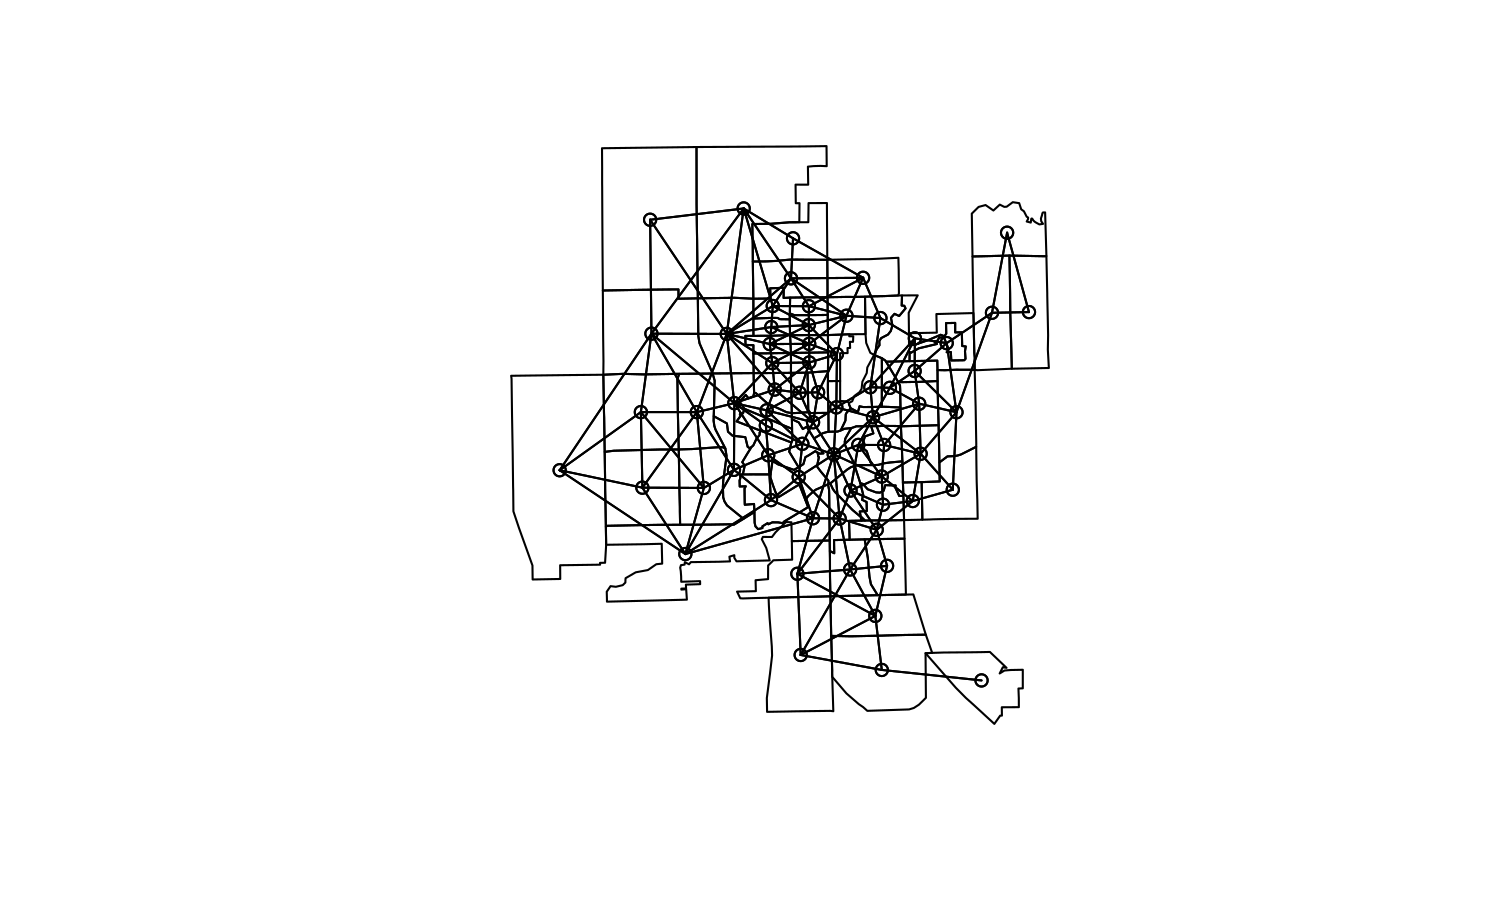

In [332]:
# install.packages("waywiser")
library(waywiser)

plot(st_geometry(df))
plot(st_centroid(st_geometry(df)), add = T)
ww_build_weights(df) %>% plot(coords = st_centroid(st_geometry(df)), add = T)

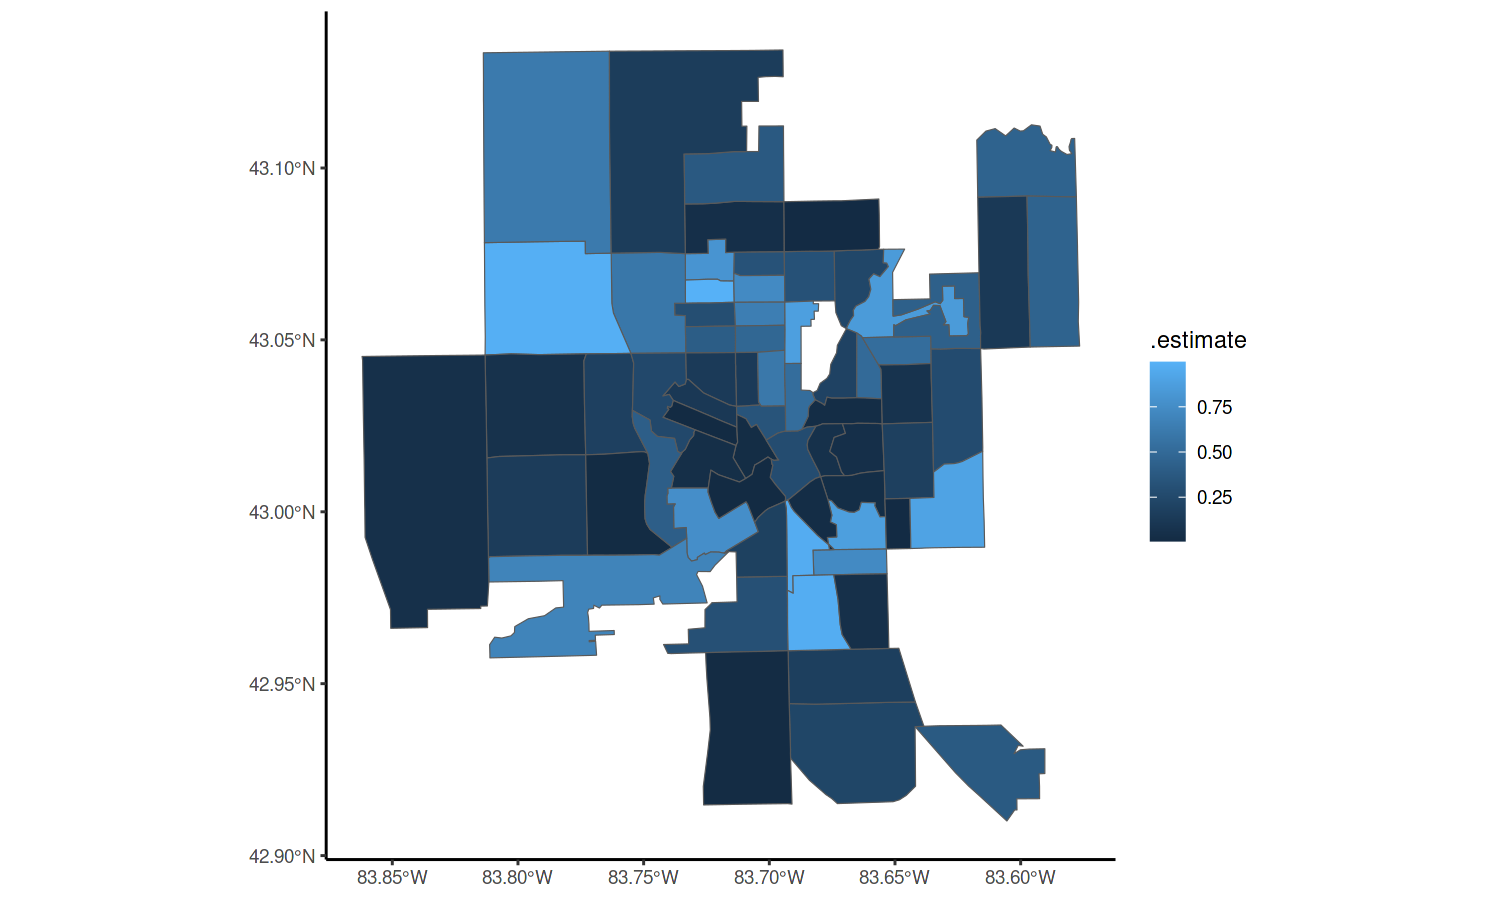

In [341]:
df %>% add_predictions(mdl) %>% ww_local_moran_pvalue(mlppb, pred) -> df2

st_geometry(df2) <- st_geometry(df)

ggplot(df2) + geom_sf(aes(fill = .estimate))

## Spatial regression
There are two types of spatial regression:
  - Spatial lag model: models dependency in the outcome
  - Spatial error model: dependency in the residuals.

In [354]:
w <- ww_build_weights(df)

mdl.lag <- lagsarlm(mlppb ~ income, data = df, listw = w)
summary(mdl.lag)


Call:lagsarlm(formula = mlppb ~ income, data = df, listw = w)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.997847 -0.597079  0.059755  0.605519  1.830010 

Type: lag 
Coefficients: (asymptotic standard errors) 
               Estimate  Std. Error z value  Pr(>|z|)
(Intercept)  2.0136e+00  4.6836e-01  4.2991 1.715e-05
income      -2.5405e-05  7.2317e-06 -3.5130 0.0004431

Rho: 0.53955, LR test value: 15.899, p-value: 6.6813e-05
Asymptotic standard error: 0.12198
    z-value: 4.4232, p-value: 9.7251e-06
Wald statistic: 19.565, p-value: 9.7251e-06

Log likelihood: -85.28357 for lag model
ML residual variance (sigma squared): 0.69764, (sigma: 0.83525)
Number of observations: 67 
Number of parameters estimated: 4 
AIC: 178.57, (AIC for lm: 192.47)
LM test for residual autocorrelation
test value: 6.0062, p-value: 0.014255


## Interpretation
- The effect of a covariate (independent variable) is the sum of two different effects: a direct, local effect of the covariate in that tract, and an indirect effect due to the spatial lag.
- I.e. in the spatial lag model there are two components to how `e` affects `mlppb`:
    - Directly
    - Indirectly, by also changing `mlppb` for neighboring tracts.


In [357]:
impacts(mdl.lag, listw = w, R = 1000) %>% summary(zstats = T, short = T)

Impact measures (lag, exact):
             Direct      Indirect         Total
income -2.74062e-05 -2.776851e-05 -5.517471e-05
Simulation results ( variance matrix):
Simulated standard errors
             Direct     Indirect        Total
income 7.707918e-06 1.964253e-05 2.381304e-05

Simulated z-values:
          Direct  Indirect    Total
income -3.559576 -1.577362 -2.45329

Simulated p-values:
       Direct     Indirect Total   
income 0.00037145 0.11471  0.014156

## Spatial error model

In [359]:
mdl.err <- errorsarlm(mlppb ~ income, data = df, listw = w)
summary(mdl.err)


Call:errorsarlm(formula = mlppb ~ income, data = df, listw = w)

Residuals:
      Min        1Q    Median        3Q       Max 
-2.059238 -0.643450  0.068152  0.600861  1.738508 

Type: error 
Coefficients: (asymptotic standard errors) 
               Estimate  Std. Error z value  Pr(>|z|)
(Intercept)  3.2538e+00  4.0496e-01  8.0349 8.882e-16
income      -2.4165e-05  8.5152e-06 -2.8379  0.004541

Lambda: 0.57323, LR test value: 11.616, p-value: 0.00065395
Asymptotic standard error: 0.12539
    z-value: 4.5717, p-value: 4.8386e-06
Wald statistic: 20.9, p-value: 4.8386e-06

Log likelihood: -87.4252 for error model
ML residual variance (sigma squared): 0.73605, (sigma: 0.85793)
Number of observations: 67 
Number of parameters estimated: 4 
AIC: 182.85, (AIC for lm: 192.47)
